In [1]:
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import os
from src.plotCurves import EvalCurves

class InputSettings(object):
    def __init__(self,
            datadir, datasets, algorithms) -> None:
        
        self.datadir = datadir
        self.datasets = datasets
        self.algorithms = algorithms


class OutputSettings(object):
    '''
    Structure for storing the names of directories that output should
    be written to
    '''

    def __init__(self, base_dir: Path) -> None:
        self.base_dir = base_dir

        
class Evaluation(object):
    '''
    The Evaluation object is created by parsing a user-provided configuration
    file. Its methods provide for further processing its inputs into
    a series of jobs to be run, as well as running these jobs.
    '''

    def __init__(self,
            input_settings: InputSettings,
            output_settings: OutputSettings) -> None:

        self.input_settings = input_settings
        self.output_settings = output_settings
        self.runners: Dict[int, Runner] = self.__create_runners()


    def __create_runners(self) -> Dict[int, List[Runner]]:
        '''
        Instantiate the set of runners based on parameters provided via the
        configuration file. Each runner is supplied an interactome, collection,
        the set of algorithms to be run, and graphspace credentials, in
        addition to the custom parameters each runner may or may not define.
        '''
        
        runners: Dict[int, Runner] = defaultdict(list)
        order = 0
        for dataset in self.input_settings.datasets:
            for runner in self.input_settings.algorithms:
                data = {}
                data['name'] = runner[0]
                data['params'] = runner[1]
                data['inputDir'] = Path.cwd().joinpath(self.input_settings.datadir.joinpath(dataset['name']))
                print(data['inputDir'])
                runners[order] = Runner(data)
                order += 1            
        return runners


    def execute_runners(self, parallel=False, num_threads=1):
        '''
        Run each of the algorithms
        '''

        base_output_dir = self.output_settings.base_dir

        batches =  self.runners.keys()

        for batch in batches:
            if parallel==True:
                executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
                futures = [executor.submit(runner.run, base_output_dir)
                    for runner in self.runners[batch]]
                
                # https://stackoverflow.com/questions/35711160/detect-failed-tasks-in-concurrent-futures
                # Re-raise exception if produced
                for future in concurrent.futures.as_completed(futures):
                    future.result()
                executor.shutdown(wait=True)
            else:
                for runner in self.runners[batch]:
                    runner.run(output_dir=base_output_dir)
                    
            
    def evaluate_runners(self):
        '''
        Plot PR and ROC curves for each dataset
        for all the algorithms
        '''
        for dataset in self.input_settings.datasets:              
            EvalCurves(dataset, self.input_settings)
                
                
class ConfigParser(object):
    '''
    Define static methods for parsing a config file that sets a large number
    of parameters for the pipeline
    '''
    @staticmethod
    def parse(config_file_handle) -> Evaluation:
        config_map = yaml.load(config_file_handle)
        return Evaluation(
            ConfigParser.__parse_input_settings(
                config_map['input_settings']),
            ConfigParser.__parse_output_settings(
                config_map['output_settings']))

    @staticmethod
    def __parse_input_settings(input_settings_map) -> InputSettings:
        input_dir = input_settings_map['input_dir']
        dataset_dir = input_settings_map['dataset_dir']
        datasets = input_settings_map['datasets']

        return InputSettings(
                Path(input_dir, dataset_dir),
                datasets,
                ConfigParser.__parse_algorithms(
                input_settings_map['algorithms']))


    @staticmethod
    def __parse_algorithms(algorithms_list):
        algorithms = []
        for algorithm in algorithms_list:
                combos = [dict(zip(algorithm['params'], val))
                    for val in itertools.product(
                        *(algorithm['params'][param]
                            for param in algorithm['params']))]
                for combo in combos:
                    algorithms.append([algorithm['name'],combo])
            

        return algorithms

    @staticmethod
    def __parse_output_settings(output_settings_map):
        output_dir = Path(output_settings_map['output_dir'])
        return OutputSettings(output_dir)

def get_parser() -> argparse.ArgumentParser:
    '''
    :return: an argparse ArgumentParser object for parsing command
        line parameters
    '''
    parser = argparse.ArgumentParser(
        description='Run pathway reconstruction pipeline.')

    parser.add_argument('--config', default='config.yaml',
        help='Configuration file')

    return parser

def parse_arguments():
    '''
    Initialize a parser and use it to parse the command line arguments
    :return: parsed dictionary of command line arguments
    '''
    parser = get_parser()
    opts = parser.parse_args()

    return opts

In [2]:
with open("config.yaml", 'r') as conf:
    evaluation = ConfigParser.parse(conf)
print(evaluation)
print('Evaluation started')

# Do something

print('Evaluation complete')

/home/adyprat/ModelEval/inputs/simulated/dataset1
/home/adyprat/ModelEval/inputs/simulated/dataset1
/home/adyprat/ModelEval/inputs/simulated/dataset1
/home/adyprat/ModelEval/inputs/simulated/dataset1
/home/adyprat/ModelEval/inputs/simulated/dataset1
Evaluation started
Evaluation complete


In [4]:
evaluation.input_settings.datasets

[{'name': 'dataset1',
  'ex_filename': 'ExpressionData.csv',
  'pt_filename': 'PseudoTime.csv',
  'trueEdges': 'reference_TFTF_network.txt'}]

In [5]:
for alg in evaluation.input_settings.algorithms:
    print(alg)

['SCODE', {'should_run': True, 'nGenes': 100, 'z': 4, 'nCells': 356, 'nIter': 100, 'nRep': 2}]
['SCNS', {'should_run': False}]
['SINCERITIES', {'should_run': True}]
['PIDC', {'should_run': True}]
['GRNVBEM', {'should_run': True}]


In [6]:
Path.cwd().joinpath(evaluation.input_settings.datadir)

PosixPath('/home/adyprat/ModelEval/inputs/simulated')

In [6]:
evaluation.runners[0].generateInputs()
evaluation.runners[0].run()
#evaluation.runners[4].run()
#evaluation.runners[4].parseOutput()

Input folder for SCODE does not exist, creating input folder...


In [5]:
#os.system("jupyter nbconvert --to script bench.ipynb")

0

In [10]:
evaluation.runners[0].parseOutput()

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

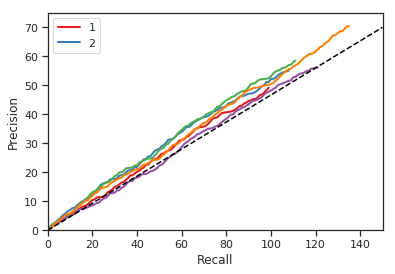

In [18]:
pDict = {}
rDict = {}
#plt.style.use('ggplot')
plt.clf()
sns.set(rc={"lines.linewidth": 2}, palette  = "Set1", style = "ticks")
keys = [1, 2, 3, 4 ,5]
for key in keys:
    pDict[key] = [0]
    rDict[key] = [0]
    for i in range(0,np.random.randint(100,150)):
        pDict[key].append(pDict[key][-1]+np.random.random())
        rDict[key].append(i)
    
for key in pDict.keys():
    sns.lineplot(rDict[key],pDict[key])

plt.plot([0, 150], [0,70], linewidth = 1.5, color = 'k', linestyle = '--')

plt.xlim(0,150)    
plt.ylim(0,75)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['1','2']) 
        


In [11]:
import pandas as pd

In [19]:
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
newDF = DF.T.copy()
pDF = pd.read_csv('inputs/simulated/dataset1/PseudoTime.csv', header= 0, index_col = 0)
newDF['Time'] = pDF['Time']
DF.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c347,c348,c349,c350,c351,c352,c353,c354,c355,c356
SOX2,1.245513,1.219480,1.273929,1.290600,1.592997,1.419606,1.269637,1.078170,1.065146,1.317938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047353
ESRRB,1.279713,1.276735,1.167757,1.228051,1.388465,1.393951,1.229218,1.164620,1.180736,1.266996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UTF1,1.417324,1.546119,1.554748,1.225030,1.775559,1.606876,1.663052,1.519041,1.575766,1.678738,...,0.000000,0.119715,0.118964,0.225039,0.000000,0.000000,0.000000,0.093533,0.037996,0.838893
EPAS1,0.551417,0.557738,0.490467,0.350676,0.896887,0.276154,0.625784,0.338052,0.428949,0.334456,...,1.305164,1.220422,1.377212,1.146544,1.452294,1.439233,1.463899,1.544450,1.302433,1.333536
FOXQ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.329386,0.924943,0.769071,1.138742,0.625939,1.030036,0.702981,0.954932,0.704600,1.116445


In [6]:
evaluation.runners

defaultdict(list,
            {0: <src.runner.Runner at 0x7fc44670c8d0>,
             1: <src.runner.Runner at 0x7fc47467d550>,
             2: <src.runner.Runner at 0x7fc47467d048>,
             3: <src.runner.Runner at 0x7fc47467d470>,
             4: <src.runner.Runner at 0x7fc47467d400>})

outputs/simulated/dataset1/SCNS/rankedEdges.csv  does not exist. Skipping...
SCODE


/home/adyprat/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


SINCERITIES
PIDC
GRNVBEM


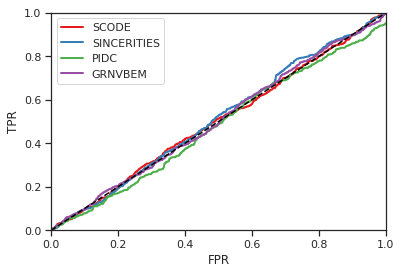

In [3]:
evaluation.evaluate_runners()

In [6]:
dataDict = evaluation.input_settings.datasets[0]

In [7]:
inputSettings = evaluation.input_settings
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

outputs/simulated/dataset1/SCNS/rankedEdges.csv  does not exist. Skipping...
SCODE
SINCERITIES
PIDC
GRNVBEM


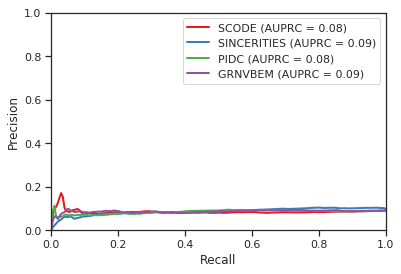

In [21]:
# Read file for trueEdges
trueEdgesFile = pd.read_csv(str(inputSettings.datadir)+'/'+ dataDict['name'] +
                            '/' +'newRef.txt',
                            sep = '\t', header = 0, index_col = None)



# Initialize data dictionaries
precisionDict = {}
recallDict = {}
FPRDict = {}
AUPRC = {}

outDir = "outputs/"+str(inputSettings.datadir).split("inputs/")[1]+ '/' +dataDict['name']
for algo in inputSettings.algorithms:
    tp = 0
    fp = 0
    total = 0 # total predictions made
    totalTrue = trueEdgesFile.shape[0] # Condition Positives
    
    # check if the output rankedEdges file exists
    if Path(outDir + '/' +algo[0]+'/rankedEdges.csv').exists():
        precisionDict[algo[0]] = [] # Initialize Precsion
        recallDict[algo[0]] = [] # Initialize Recall
        FPRDict[algo[0]] = [] # Initialize FPR
        predEdgesFile = pd.read_csv(outDir + '/' +algo[0]+'/rankedEdges.csv', \
                                    sep = '\t', header =  0, index_col = None)
        pOld = 0
        rOld = 0
        AUPRC[algo[0]] = 0 # Initialize AUPRC
        for idx, row in predEdgesFile.iterrows():
            if trueEdgesFile.loc[(trueEdgesFile['Gene1'] == row['Gene1']) & \
                                 (trueEdgesFile['Gene2'] == row['Gene2'])].shape[0] > 0:
                tp += 1
            else:
                fp += 1
            total += 1

            pNew = float(tp)/float(total)
            rNew = float(tp)/float(totalTrue)

            precisionDict[algo[0]].append(pNew)
            recallDict[algo[0]].append(rNew)

            AUPRC[algo[0]] += ((rNew - rOld)*(pOld + pNew)/2) # compute AUPRC

            pOld = pNew
            rOld = rNew
            FPRDict[algo[0]].append(float(fp)) # List of FP values

        FPRDict[algo[0]] = [val/float(total - totalTrue) for val in FPRDict[algo[0]]] # update FPR

    else:
        print(outDir + '/' +algo[0]+'/rankedEdges.csv', \
              ' does not exist. Skipping...')

## Make PR curves
legendList = []
for key in precisionDict.keys():
    print(key)
    sns.lineplot(recallDict[key],precisionDict[key])
    legendList.append(str(key) + ' (AUPRC = ' + str("%.2f" % (AUPRC[key]))+')')

plt.xlim(0,1)    
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legendList) 

In [19]:
fp

1593

In [8]:
import pandas as pd
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
pDF = pd.read_csv('inputs/simulated/dataset1/PseudoTime.csv', header= 0, index_col = 0)
DF[pDF.sort_values(['PseudoTime']).index].head()

,c33,c53,c3,c47,c67,c30,c64,c49,c20,c18,...,c318,c319,c315,c306,c328,c301,c343,c346,c307,c337
SOX2,1.207739,1.131859,1.273929,1.228341,1.207457,1.347742,1.294244,1.270301,0.673372,1.167187,...,0.000000,0.000000,0.022750,0.012577,0.000000,0.000000,0.000000,0.000000,0.000000,0.041987
ESRRB,1.309502,1.382944,1.167757,1.278879,1.362136,1.461041,1.200626,1.466985,1.365031,1.262795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UTF1,0.887411,1.067413,1.554748,1.571531,1.322056,1.638627,1.428033,1.239905,1.686085,1.522945,...,0.000000,0.064483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.338938
EPAS1,0.078518,0.374048,0.490467,0.673594,0.558087,0.528945,0.477813,0.286092,0.240735,0.618417,...,1.412113,1.457596,1.317854,1.340016,1.362222,1.698906,1.596973,1.522050,1.471538,1.709350
FOXQ1,0.000000,0.000000,0.000000,0.000000,0.047418,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.925106,0.939707,1.277891,0.870892,1.144854,0.966274,0.495990,0.899653,1.077230,0.913330


In [26]:
NetDF = pd.read_csv('inputs/simulated/dataset1/reference_TFTF_network.txt', sep = '\t', header= 0, index_col = None)
DF.loc[pd.unique(NetDF[['Gene1','Gene2']].values.ravel('K'))].to_csv('inputs/simulated/dataset1/ExpressionData.csv',\
                                                                     sep = ',', header  = True, index = True)

Parent             ELF3
Type                  +
Child              ELF3
Weight         0.247965
Probability           1
Score          0.625165
Name: 0, dtype: object
Parent             SIX1
Type                  +
Child              SIX1
Weight         0.294105
Probability           1
Score          0.741493
Name: 1344, dtype: object
Parent            GATA6
Type                  +
Child             TRP53
Weight         0.146964
Probability           1
Score          0.370523
Name: 272, dtype: object
Parent            NANOG
Type                  +
Child              ETV4
Weight         0.232282
Probability           1
Score          0.585625
Name: 325, dtype: object
Parent            FOXH1
Type                  +
Child             FOXH1
Weight         0.240197
Probability           1
Score          0.605581
Name: 384, dtype: object
Parent            GATA6
Type                  +
Child             GATA4
Weight         0.223489
Probability           1
Score          0.563456
Name: 1541, 

Parent            PARP1
Type                  +
Child               ERF
Weight         0.118477
Probability    0.973817
Score          0.290882
Name: 941, dtype: object
Parent            SOX17
Type                  +
Child              ETS1
Weight          0.10562
Probability    0.973544
Score          0.259244
Name: 1057, dtype: object
Parent             ETV4
Type                  +
Child             NR0B1
Weight         0.183722
Probability    0.973426
Score          0.450887
Name: 2121, dtype: object
Parent            FOXH1
Type                  +
Child             ESRRB
Weight         0.142061
Probability    0.973059
Score          0.348514
Name: 1371, dtype: object
Parent            RUNX1
Type                  +
Child             FOXA2
Weight         0.119047
Probability    0.972937
Score          0.292017
Name: 1796, dtype: object
Parent             MSX2
Type                  +
Child              XBP1
Weight         0.161588
Probability    0.972801
Score          0.396313
Name: 2

Parent             ETV4
Type                  +
Child              ETV5
Weight         0.099264
Probability    0.749279
Score          0.187517
Name: 429, dtype: object
Parent             ETV4
Type                  +
Child            POU5F1
Weight         0.105106
Probability    0.748922
Score          0.198458
Name: 1651, dtype: object
Parent             SOX7
Type                  -
Child             FOXH1
Weight         -0.07893
Probability     0.74864
Score         -0.148977
Name: 409, dtype: object
Parent              JUN
Type                  +
Child              KLF4
Weight         0.152535
Probability    0.748588
Score          0.287884
Name: 1921, dtype: object
Parent            FOXH1
Type                  +
Child              RARG
Weight         0.056037
Probability    0.748187
Score          0.105703
Name: 1606, dtype: object
Parent            ESRRB
Type                  -
Child              ELF2
Weight        -0.071071
Probability    0.747582
Score         -0.133954
Name: 78

Parent            ESRRB
Type                  -
Child             FOXQ1
Weight        -0.079177
Probability    0.460655
Score         -0.091956
Name: 1439, dtype: object
Parent             ETV4
Type                  +
Child             MYBL2
Weight         0.064753
Probability    0.460655
Score          0.075204
Name: 711, dtype: object
Parent             GLI2
Type                  +
Child             NFIL3
Weight         0.059085
Probability    0.460295
Score          0.068567
Name: 353, dtype: object
Parent             ETS1
Type                  -
Child              REST
Weight        -0.077773
Probability     0.45886
Score         -0.089973
Name: 868, dtype: object
Parent             REST
Type                  +
Child             HMGA2
Weight          0.06757
Probability    0.457633
Score          0.077961
Name: 1193, dtype: object
Parent             ETV5
Type                  +
Child           BHLHE40
Weight         0.075442
Probability    0.457556
Score          0.087029
Name: 902

Parent             ELF2
Type                  +
Child             HNF1B
Weight         0.048416
Probability     0.32445
Score          0.039604
Name: 1238, dtype: object
Parent             ELF2
Type                  +
Child              MYCN
Weight         0.064386
Probability    0.324167
Score          0.052622
Name: 1285, dtype: object
Parent            RHOX6
Type                  +
Child             HMGA2
Weight          0.05796
Probability    0.323661
Score          0.047296
Name: 1221, dtype: object
Parent            FOXD3
Type                  +
Child               JUN
Weight         0.050358
Probability    0.323308
Score          0.041048
Name: 1969, dtype: object
Parent             ELF2
Type                  -
Child           BHLHE40
Weight        -0.052785
Probability    0.323179
Score         -0.043009
Name: 909, dtype: object
Parent             RARG
Type                  +
Child            TCF7L2
Weight         0.029834
Probability    0.322479
Score          0.024256
Name: 6

Parent             ELF2
Type                  +
Child              SOX2
Weight         0.026887
Probability     0.25872
Score          0.017538
Name: 1849, dtype: object
Parent             KLF4
Type                  -
Child             HMGA2
Weight        -0.040972
Probability    0.258457
Score         -0.026698
Name: 1215, dtype: object
Parent            FOXQ1
Type                  +
Child              ETS1
Weight         0.037876
Probability    0.258247
Score          0.024661
Name: 1064, dtype: object
Parent             GLI1
Type                  -
Child              RBPJ
Weight        -0.000361
Probability    0.258087
Score         -0.000235
Name: 802, dtype: object
Parent             ETS1
Type                  -
Child             TGIF1
Weight        -0.040926
Probability    0.257819
Score         -0.026603
Name: 539, dtype: object
Parent             RBPJ
Type                  -
Child             EPAS1
Weight        -0.054386
Probability    0.257719
Score         -0.035338
Name: 17

Parent             XBP1
Type                  -
Child             TGIF1
Weight        -0.006973
Probability    0.194293
Score         -0.003415
Name: 521, dtype: object
Parent             ELF3
Type                  +
Child              GLI1
Weight         0.022184
Probability    0.194109
Score          0.010856
Name: 141, dtype: object
Parent            NFIL3
Type                  +
Child            TCF7L2
Weight         0.035658
Probability    0.193767
Score           0.01742
Name: 665, dtype: object
Parent            FOXQ1
Type                  +
Child           BHLHE40
Weight         0.034448
Probability    0.193664
Score           0.01682
Name: 923, dtype: object
Parent            HMGA2
Type                  -
Child             ZFP42
Weight        -0.022676
Probability    0.192902
Score         -0.011028
Name: 2093, dtype: object
Parent            SMAD7
Type                  +
Child             ZFP42
Weight         0.015047
Probability    0.192836
Score          0.007315
Name: 2081

Name: 1475, dtype: object
Parent           TCF7L2
Type                  +
Child              GLI2
Weight         0.002466
Probability    0.154518
Score          0.000961
Name: 1142, dtype: object
Parent             SIX1
Type                  +
Child              SOX7
Weight         0.035296
Probability     0.15442
Score          0.013741
Name: 1579, dtype: object
Parent              ERF
Type                  -
Child             FOXD3
Weight        -0.004511
Probability     0.15437
Score         -0.001756
Name: 1994, dtype: object
Parent            FOXQ1
Type                  -
Child            POU5F1
Weight        -0.016904
Probability    0.154333
Score         -0.006577
Name: 1675, dtype: object
Parent             ELF3
Type                  -
Child             SMAD7
Weight        -0.019208
Probability    0.153822
Score         -0.007449
Name: 611, dtype: object
Parent           TCF7L2
Type                  +
Child              ETV4
Weight         0.001581
Probability      0.1537
Score